### Chess Games
To begin, we need to prepare the data that is readily available for us in `games.csv`. There are 6 columns that will be kept which are turns, white_rating, black_rating, rated, winner and first_move. From all of these columns, we will have to parse the moves column to receive the first_move and then use one hot encoding to successfully run our algorithms on the categorical data. 

Number of entries: 18132
Number of features: 6
   turns  white_rating  black_rating  rated winner  first_move_Nc3  \
1     16          1322          1261   True  black           False   
2     61          1496          1500   True  white           False   
3     61          1439          1454   True  white           False   
4     95          1523          1469   True  white           False   
6     33          1520          1423   True  white           False   
8     66          1439          1392   True  black           False   
9    119          1381          1209   True  white           False   

   first_move_Nf3  first_move_Nh3  first_move_a3  first_move_a4  ...  \
1           False           False          False          False  ...   
2           False           False          False          False  ...   
3           False           False          False          False  ...   
4           False           False          False          False  ...   
6           False           Fals

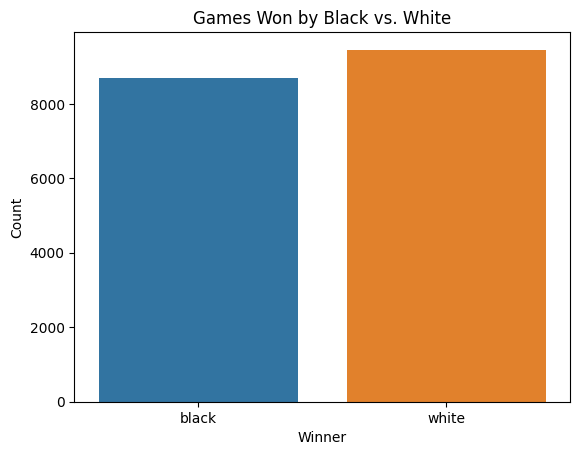

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from graphs import plot_learning_curve
import constants
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load your dataset
d = pd.read_csv('./datasets/games.csv')
# filtered_data = d[(d['turns'] >= 15) | (d['victory_status'] != 'draw') | (d['winner'] != 'draw')].copy()# Use .copy() to ensure you are working on a copy
filtered_data = d[(d['turns'] >= 15) & (d['winner'] != 'draw')].copy()

# Define the target column and set random_state
target_column = 'winner'

# parse out the first move
filtered_data['moves'] = filtered_data['moves'].str.split()
filtered_data['first_move'] = filtered_data['moves'].str[0]
# filtered_data['second_move'] = filtered_data['moves'].str[1] #TODO: If I want to include the second move

# List the columns to keep - and drop the rest 
columns_to_keep = ["turns", "white_rating", "black_rating", "rated", "winner", "first_move"]
data = filtered_data[columns_to_keep]

# Create one-hot encoding for the "first_move" column, and drop the first_move column
one_hot_encoded = pd.get_dummies(data['first_move'], prefix='first_move', drop_first=True)
data_encoded = pd.concat([data, one_hot_encoded], axis=1)
data_encoded = data_encoded.drop(columns=['first_move'])

# Set the X and y for the data 
X = data_encoded.drop(columns=[target_column])
y = data_encoded[target_column]

# Print out data and stats to ensure correct
num_entries = data.shape[0]
print("Number of entries:", num_entries)
num_features = data.shape[1]
print("Number of features:", num_features)
print(data_encoded.head(7))
counts = data_encoded['winner'].value_counts()
print("counts", counts)
sns.countplot(data=data_encoded, x='winner')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.title('Games Won by Black vs. White')
plt.show()

Next we must split the data into the training and tests set. 

In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=constants.TEST_SIZE, random_state=constants.RANDOM_STATE)

Run Scaling for the data to be used in the SVM, NN, and kNN. These are algorithms which always benefit from scaling the data.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Decision Tree
Train using the values for a decision tree, and then plot the learning curve using the cross validation value set globally.

In [34]:
from dt import dt

# Create a GridSearchCV object for hyperparameter tuning
param_grid = {
    'max_depth': [ None],  # You can include 'None' for unlimited depth
    'min_samples_split': [2], #do not use 1 or less.
    'min_samples_leaf': [1]
}

best_dt_model, best_dt_params = dt(X_train, X_test, y_train, y_test, param_grid)


Decision Tree took 0.05131721496582031 seconds to train.
Decision Tree took 0.0015249252319335938 seconds to execute.

Decision tree train report
               precision    recall  f1-score   support

       black   1.000000  1.000000  1.000000      6954
       white   1.000000  1.000000  1.000000      7551

    accuracy                       1.000000     14505
   macro avg   1.000000  1.000000  1.000000     14505
weighted avg   1.000000  1.000000  1.000000     14505


Decision tree test report
               precision    recall  f1-score   support

       black   0.610795  0.622827  0.616753      1726
       white   0.651312  0.639663  0.645435      1901

    accuracy                       0.631652      3627
   macro avg   0.631054  0.631245  0.631094      3627
weighted avg   0.632031  0.631652  0.631786      3627

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Tree Size: 8003
Number of Leaves: 4002


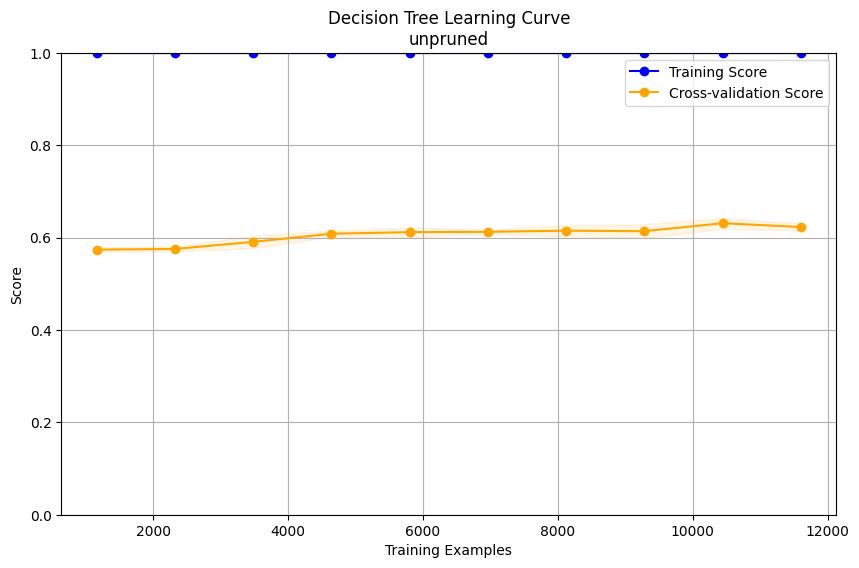

In [36]:
title="unpruned"
plot_learning_curve(best_dt_model, X_train, y_train, scoring='accuracy', title="Decision Tree Learning Curve\n{title}")

### Neural Networks

In [11]:
from nn import nn

param_grid = {
    'hidden_layer_sizes': [(64,)],
    'learning_rate_init': [0.1]
}

best_nn_model, best_nn_params = nn(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)

Best Hyperparameters: {'hidden_layer_sizes': (64,), 'learning_rate_init': 0.1}

NN train report
               precision    recall  f1-score   support

       black   0.625258  0.609433  0.617244      6954
       white   0.648505  0.663621  0.655976      7551

    accuracy                       0.637642     14505
   macro avg   0.636882  0.636527  0.636610     14505
weighted avg   0.637360  0.637642  0.637407     14505


NN test report
               precision    recall  f1-score   support

       black   0.638958  0.596756  0.617136      1726
       white   0.654591  0.693845  0.673647      1901

    accuracy                       0.647643      3627
   macro avg   0.646774  0.645300  0.645391      3627
weighted avg   0.647151  0.647643  0.646755      3627

NN took 0.003173828125 seconds to execute.


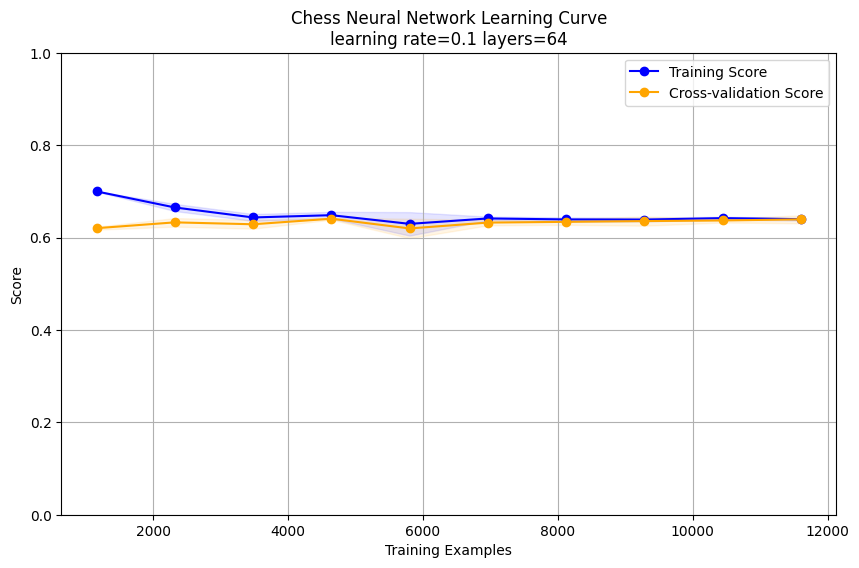

In [13]:
title="learning rate=0.1 layers=64"
plot_learning_curve(best_nn_model, X_train_scaled, y_train, scoring='accuracy', title=f"Chess Neural Network Learning Curve\n{title}")

### K-Nearest Neighbors
Use the scaled sets for training.

In [26]:
from knn import knn

param_grid = {
    'n_neighbors': [90],
    'weights': ['distance'],
    'p': [2]
}

best_knn_model, best_knn_params = knn(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)


Best Hyperparameters: {'n_neighbors': 90, 'p': 2, 'weights': 'distance'}

knn train report
               precision    recall  f1-score   support

       black   1.000000  1.000000  1.000000      6954
       white   1.000000  1.000000  1.000000      7551

    accuracy                       1.000000     14505
   macro avg   1.000000  1.000000  1.000000     14505
weighted avg   1.000000  1.000000  1.000000     14505


knn test report
               precision    recall  f1-score   support

       black   0.668631  0.591541  0.627728      1726
       white   0.664286  0.733824  0.697326      1901

    accuracy                       0.666115      3627
   macro avg   0.666459  0.662683  0.662527      3627
weighted avg   0.666354  0.666115  0.664206      3627

K-NN took 0.1038060188293457 seconds to execute.


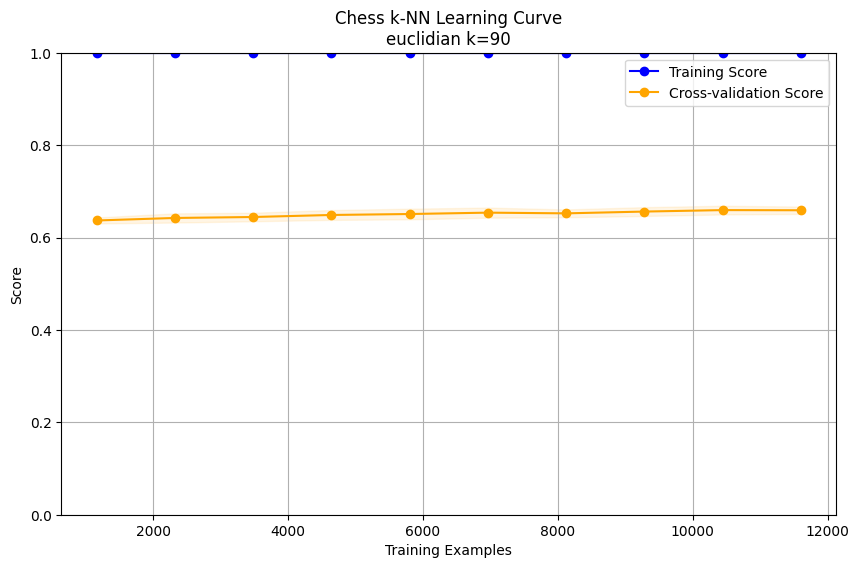

In [27]:
title="euclidian k=90"
plot_learning_curve(best_knn_model, X_train, y_train, scoring='accuracy', title=f"Chess k-NN Learning Curve\n{title}")

### Boosted Decision Tree Classifier

In [13]:
from dt import ada_boosted_dt

# Define the parameter grid for AdaBoost
param_grid = {
    'base_estimator__max_depth': [10],  # Adjust max_depth as needed
    'n_estimators': [50],  # Number of Decision Trees in the ensemble
    'learning_rate': [0.1]
}

best_bdt_model, best_bdt_params = ada_boosted_dt(X_train, X_test, y_train, y_test, param_grid)



Best AdaBoost Decision Tree Hyperparameters: {'base_estimator__max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 50}

NN train report
               precision    recall  f1-score   support

       black   1.000000  1.000000  1.000000      6954
       white   1.000000  1.000000  1.000000      7551

    accuracy                       1.000000     14505
   macro avg   1.000000  1.000000  1.000000     14505
weighted avg   1.000000  1.000000  1.000000     14505


NN test report
               precision    recall  f1-score   support

       black   0.812929  0.823291  0.818077      1726
       white   0.837680  0.827985  0.832804      1901

    accuracy                       0.825751      3627
   macro avg   0.825304  0.825638  0.825441      3627
weighted avg   0.825901  0.825751  0.825796      3627

DTADA Boosting took 0.017633914947509766 seconds to execute.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/

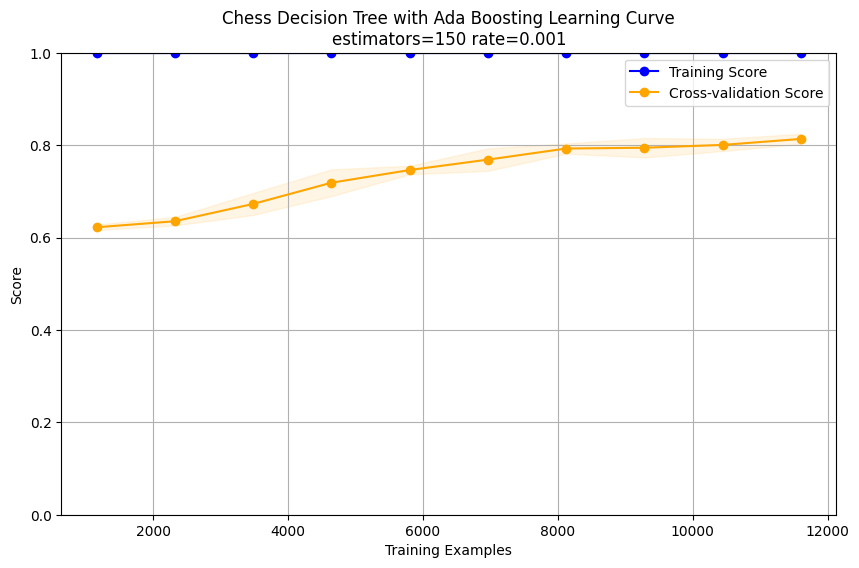

In [14]:
from graphs import plot_learning_curve
title="estimators=150 rate=0.001"
plot_learning_curve(best_bdt_model, X_train, y_train, scoring='accuracy', title=f"Chess Decision Tree with Ada Boosting Learning Curve\n{title}")

### Support Vector Machine


In [9]:
from svm import svm

# Set the param grid
param_grid = {
    'C': [10],
    'kernel': ['rbf'],
    'gamma': [0.01],
}

# Pass the scaled data to the svm
best_svm_model, best_svm_params = svm(X_train_scaled, X_test_scaled, y_train, y_test, param_grid)


Best Hyperparameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Boosting took 0.15170717239379883 seconds to execute.
SVM Boosting took 0.04229593276977539 seconds to train.

SVM train report
               precision    recall  f1-score   support

       black   0.743590  0.118126  0.203866       491
       white   0.530369  0.960707  0.683438       509

    accuracy                       0.547000      1000
   macro avg   0.636979  0.539417  0.443652      1000
weighted avg   0.635060  0.547000  0.447968      1000


SVM test report
               precision    recall  f1-score   support

       black   0.595331  0.088644  0.154312      1726
       white   0.533234  0.945292  0.681844      1901

    accuracy                       0.537634      3627
   macro avg   0.564283  0.516968  0.418078      3627
weighted avg   0.562785  0.537634  0.430804      3627



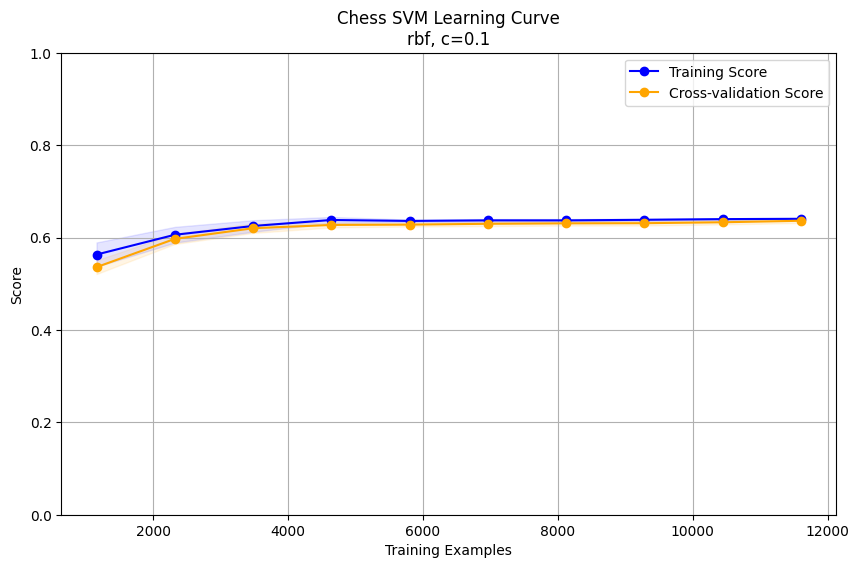

In [10]:
title="rbf, c=0.1"
plot_learning_curve(best_svm_model, X_train_scaled, y_train, scoring='accuracy', title=f"Chess SVM Learning Curve\n{title}")